# Toy Example

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(root))

%load_ext autoreload
%autoreload 2

## Import Packages

In [2]:
# Data
# from survae.data.datasets.toy import TwoMoonsDataset, SineWaveDataset, CheckerboardDataset
from torch.utils.data import DataLoader, Dataset# Model
import torch
import torch.nn as nn
from survae.flows import Flow
from survae.distributions import StandardNormal


# Optim
from torch.optim import Adam

# Plot
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [3]:
class PlaneDataset(Dataset):
    def __init__(self, data, transform=None):
        self.num_points = data.shape[0]
        self.data = data
        self.transform = transform

    def __getitem__(self, item):
        
        # select data
        X = self.data[item]
        
        # transforms
        if self.transform is not None:
            X = self.transform(X)
            
        return X

    def __len__(self):
        return self.num_points

        
        
# from sklearn.datasets import make_moons
# class TwoMoonsDataset(PlaneDataset):
#     '''Adapted from https://github.com/rtqichen/ffjord/blob/master/lib/toy_data.py'''
#     def _create_data(self):
#         data = make_moons(n_samples=self.num_points, noise=0.1, random_state=0)[0]
#         data = data.astype("float32")
#         data = data * 2 + np.array([-1, -0.2])
#         self.data = torch.from_numpy(data).float()

In [4]:
from sklearn.datasets import make_moons
from pl_bolts.datamodules import SklearnDataModule, SklearnDataset
from torchvision.transforms import Compose, ToTensor

ntrain = 5_000
ntest = 2_000
noise = 0.1
random_state = 123
train_data = make_moons(n_samples=ntrain, noise=noise, random_state=random_state)[0]
test_data = make_moons(n_samples=ntest, noise=noise, random_state=random_state*10)[0]

# transformations
preprocess_transforms = None
train_ds = PlaneDataset(torch.FloatTensor(train_data), transform=preprocess_transforms)
test_ds = PlaneDataset(torch.FloatTensor(test_data), transform=preprocess_transforms)

# create dataloaders
train_loader = DataLoader(train_ds, batch_size=128, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=True)

In [5]:
# train = TwoMoonsDataset(num_points=128*1000)
# test = TwoMoonsDataset(num_points=128*1000)


In [6]:
# GF (Logistic Kernel CDF)
num_mixtures = 12

from survae.distributions import StandardNormal
from survae.transforms.bijections.elementwise_nonlinear import GaussianMixtureCDF, InverseGaussCDF
from survae.transforms.bijections.linear_orthogonal import FastHouseholder

model = Flow(base_dist=StandardNormal((2,)),
             transforms=[
#     Augment(StandardNormal((1,)), x_size=1),
    GaussianMixtureCDF((2,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(2, 2),
    GaussianMixtureCDF((2,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(2, 2),
    GaussianMixtureCDF((2,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(2, 2),
    GaussianMixtureCDF((2,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(2, 2),
    GaussianMixtureCDF((2,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(2, 2),
    GaussianMixtureCDF((2,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(2, 2),
    GaussianMixtureCDF((2,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(2, 2),
    GaussianMixtureCDF((2,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(2, 2),
    GaussianMixtureCDF((2,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(2, 2),
    GaussianMixtureCDF((2,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(2, 2),
    GaussianMixtureCDF((2,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(2, 2),
    GaussianMixtureCDF((2,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(2, 2),
             ])

## MarkDown

In [7]:
# from survae.transforms import AffineCouplingBijection, ActNormBijection, Reverse
# from survae.transforms import LogisticMixtureCouplingBijection, RationalQuadraticSplineCouplingBijection, GaussianMixtureCouplingBijection
# from survae.transforms import Sigmoid, Logit
# from survae.transforms.bijections.elementwise_nonlinear import GaussianMixtureCDF, LogisticMixtureCDF, RQSplineCDF, InverseGaussCDF, KernelLogisticCDF
# from survae.transforms import Linear
# from survae.transforms.bijections.linear_orthogonal import LinearHouseholder, FastHouseholder
# from survae.transforms.bijections.conv1x1 import Conv1x1Householder
# from survae.nn.layers import ElementwiseParams

# def net(n_features):
#     return nn.Sequential(nn.Linear(1, 200), nn.ReLU(),
#                        nn.Linear(200, 100), nn.ReLU(),
#                        nn.Linear(100, n_features), ElementwiseParams(n_features))

# # RealNVP Model
# model = Flow(base_dist=StandardNormal((2,)),
#              transforms=[
#                AffineCouplingBijection(net(2)), ActNormBijection(2), Reverse(2),
#                AffineCouplingBijection(net(2)), ActNormBijection(2), Reverse(2),
#                AffineCouplingBijection(net(2)), ActNormBijection(2), Reverse(2),
#                AffineCouplingBijection(net(2)), ActNormBijection(2),
#              ])

# # Flow++ Model
# num_mixtures = 8
# num_params = 3 * num_mixtures

# def net(n_features):
#     return nn.Sequential(nn.Linear(1, 200), nn.ReLU(),
#                        nn.Linear(200, 100), nn.ReLU(),
#                        nn.Linear(100, num_params), ElementwiseParams(num_params))

# model = Flow(base_dist=StandardNormal((2,)),
#              transforms=[
#                Sigmoid(), LogisticMixtureCouplingBijection(net(2), num_mixtures=num_mixtures), Logit(), Reverse(2),
#                Sigmoid(), LogisticMixtureCouplingBijection(net(2), num_mixtures=num_mixtures), Logit(), Reverse(2),
#                Sigmoid(), LogisticMixtureCouplingBijection(net(2), num_mixtures=num_mixtures), Logit(), Reverse(2),
#                Sigmoid(), LogisticMixtureCouplingBijection(net(2), num_mixtures=num_mixtures), Logit(),
#              ])
# # model = Flow(base_dist=StandardNormal((2,)),
# #              transforms=[
# #                GaussianMixtureCouplingBijection(net(2), num_mixtures=num_mixtures), Logit(), Reverse(2),
# #                GaussianMixtureCouplingBijection(net(2), num_mixtures=num_mixtures), Logit(), Reverse(2),
# #                GaussianMixtureCouplingBijection(net(2), num_mixtures=num_mixtures), Logit(), Reverse(2),
# #                GaussianMixtureCouplingBijection(net(2), num_mixtures=num_mixtures), Logit(),
# #              ])


# # Marginal GF (1 Layer)
# num_mixtures = 8
# num_params = 3 * num_mixtures

# def net(n_features):
#     return nn.Sequential(nn.Linear(1, 200), nn.ReLU(),
#                        nn.Linear(200, 100), nn.ReLU(),
#                        nn.Linear(100, num_params), ElementwiseParams(num_params))

# model = Flow(base_dist=StandardNormal((2,)),
#              transforms=[
#                 GaussianMixtureCDF((2,), num_mixtures=num_mixtures), Logit()
#              ])

# # GF (Logistic Mixture CDF)
# num_mixtures = 12


# model = Flow(base_dist=StandardNormal((2,)),
#              transforms=[
#     LogisticMixtureCDF((2,), num_mixtures=num_mixtures), Logit(), LinearHouseholder(2, 2),
#     LogisticMixtureCDF((2,), num_mixtures=num_mixtures), Logit(), LinearHouseholder(2, 2),
#     LogisticMixtureCDF((2,), num_mixtures=num_mixtures), Logit(), LinearHouseholder(2, 2),
#     LogisticMixtureCDF((2,), num_mixtures=num_mixtures), Logit(), LinearHouseholder(2, 2),
#     LogisticMixtureCDF((2,), num_mixtures=num_mixtures), Logit(), LinearHouseholder(2, 2),
#     LogisticMixtureCDF((2,), num_mixtures=num_mixtures), Logit(), LinearHouseholder(2, 2),
#     LogisticMixtureCDF((2,), num_mixtures=num_mixtures), Logit(), LinearHouseholder(2, 2),
#     LogisticMixtureCDF((2,), num_mixtures=num_mixtures), Logit(), LinearHouseholder(2, 2),
#     LogisticMixtureCDF((2,), num_mixtures=num_mixtures), Logit(), LinearHouseholder(2, 2),
#     LogisticMixtureCDF((2,), num_mixtures=num_mixtures), Logit(), LinearHouseholder(2, 2),
#     LogisticMixtureCDF((2,), num_mixtures=num_mixtures), Logit(), LinearHouseholder(2, 2),
#     LogisticMixtureCDF((2,), num_mixtures=num_mixtures), Logit(),
#              ])

# # GF (Logistic Mixture CDF)
# num_mixtures = 12


# model = Flow(base_dist=StandardNormal((2,)),
#              transforms=[
#     GaussianMixtureCDF((2,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(2, 2),
#     GaussianMixtureCDF((2,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(2, 2),
#     GaussianMixtureCDF((2,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(2, 2),
#     GaussianMixtureCDF((2,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(2, 2),
#     GaussianMixtureCDF((2,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(2, 2),
#     GaussianMixtureCDF((2,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(2, 2),
#              ])




# # GF (NSF)
# num_bins = 4
# num_layers = 12


# model = Flow(base_dist=StandardNormal((2,)),
#              transforms=[
#                  RQSplineCDF((2,), num_bins=num_bins), LinearHouseholder(2, 2), 
#                  RQSplineCDF((2,), num_bins=num_bins), LinearHouseholder(2, 2),
#                  RQSplineCDF((2,), num_bins=num_bins), LinearHouseholder(2, 2),
#                  RQSplineCDF((2,), num_bins=num_bins), LinearHouseholder(2, 2),
#                  RQSplineCDF((2,), num_bins=num_bins), LinearHouseholder(2, 2),
#                  RQSplineCDF((2,), num_bins=num_bins), LinearHouseholder(2, 2),
#                  RQSplineCDF((2,), num_bins=num_bins), LinearHouseholder(2, 2),
#              ])


# # NSF Model
# num_bins = 8
# num_params = 3 * num_bins + 1

# def net(n_features):
#     return nn.Sequential(nn.Linear(1, 200), nn.ReLU(),
#                        nn.Linear(200, 100), nn.ReLU(),
#                        nn.Linear(100, num_params), ElementwiseParams(num_params))
# model = Flow(base_dist=StandardNormal((2,)),
#              transforms=[
#                Sigmoid(), RationalQuadraticSplineCouplingBijection(net(2), num_bins=num_bins), Logit(), Reverse(2),
#                Sigmoid(), RationalQuadraticSplineCouplingBijection(net(2), num_bins=num_bins), Logit(), Reverse(2),
#                Sigmoid(), RationalQuadraticSplineCouplingBijection(net(2), num_bins=num_bins), Logit(), Reverse(2),
#                Sigmoid(), RationalQuadraticSplineCouplingBijection(net(2), num_bins=num_bins), Logit(),
#              ])


### Demo Data

In [8]:
test_x = torch.Tensor(train_ds.data[:50_000])

In [9]:
loss = model.log_prob(test_x)


In [10]:
z, ldj = model.forward_transform(test_x)
x_approx = model.inverse_transform(z)



In [11]:
# torch.testing.assert_allclose(test_x, x_approx)

In [12]:
import corner

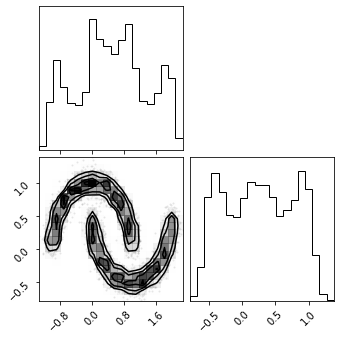

In [13]:
fig = corner.corner(test_x.detach().numpy())

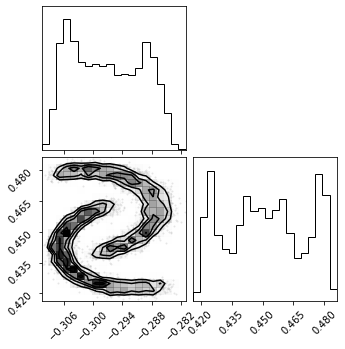

In [14]:
fig = corner.corner(z.detach().numpy())

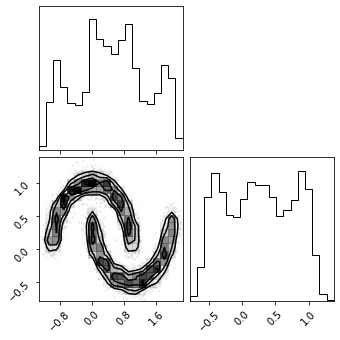

In [15]:
fig = corner.corner(x_approx.detach().numpy())

## Trainer

In [16]:
import pytorch_lightning as pl

class Learner2DPlane(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        
        # loss function
        loss = -self.model.log_prob(batch).mean()
        
        return {'loss': loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=1e-2)

    def train_dataloader(self):
        return train_loader

In [17]:
# initialize trainer
learn = Learner2DPlane(model)

In [18]:
n_epochs = 500

# initialize trainer
trainer = pl.Trainer(min_epochs=1, max_epochs=n_epochs, gpus=0)

# train model
trainer.fit(learn)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name  | Type | Params
-------------------------------
0 | model | Flow | 912   
-------------------------------
912       Trainable params
0         Non-trainable params
912       Total params
0.004     Total estimated model params size (MB)
/Users/eman/miniconda3/envs/survae_flows/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/eman/miniconda3/envs/survae_flows/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:393: UserWarning: The number of training samples (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower 

Training: 0it [00:00, ?it/s]

## Latent Space

In [19]:
z_latent, ldj = model.forward_transform(test_x)

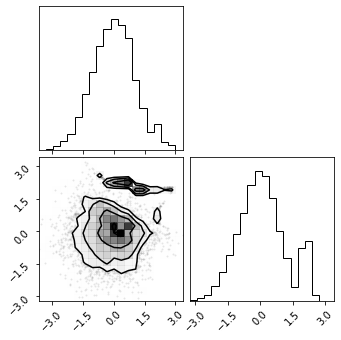

In [20]:
fig = corner.corner(z_latent.detach().numpy())

## Sampling

In [21]:
%%time
print('Sampling...')

samples = model.sample(10_000).detach().numpy()

Sampling...
CPU times: user 7.22 s, sys: 160 ms, total: 7.38 s
Wall time: 2.7 s


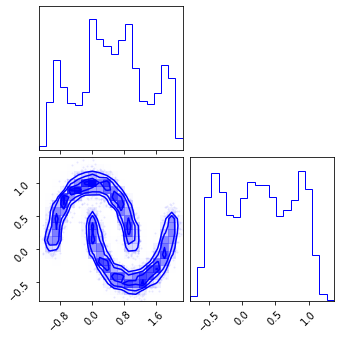

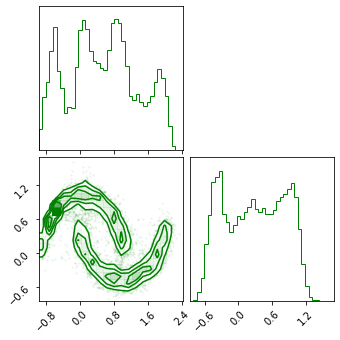

In [22]:
data = test_x.detach().numpy()

fig = corner.corner(data, color="blue")


fig = corner.corner(samples, color="green", hist_bin_factor=2, )

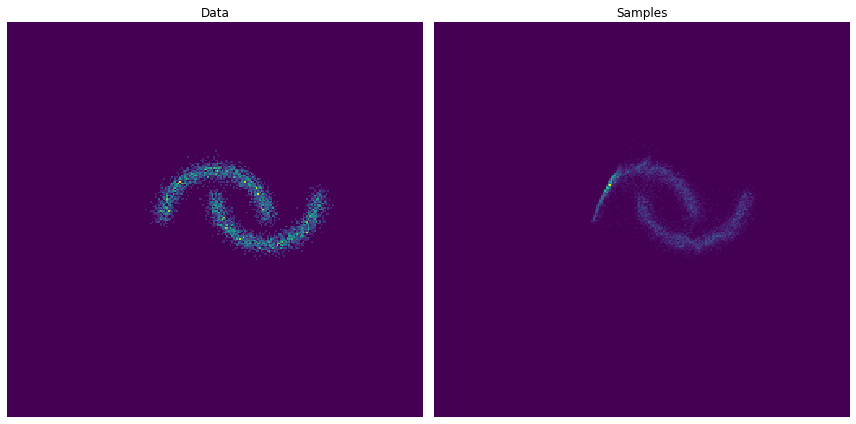

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].set_title('Data')
ax[0].hist2d(data[...,0], data[...,1], bins=256, range=[[-4, 4], [-4, 4]])
ax[0].set_xlim([-4, 4]); ax[0].set_ylim([-4, 4]); ax[0].axis('off')
ax[1].set_title('Samples')
ax[1].hist2d(samples[...,0], samples[...,1], bins=256, range=[[-4, 4], [-4, 4]])
ax[1].set_xlim([-4, 4]); ax[1].set_ylim([-4, 4]); ax[1].axis('off')
plt.tight_layout()
plt.show()

